# Video Pinball

This project aims to teach a reinforcement learning agent to play the game [Atari Video Pinball](https://gymnasium.farama.org/environments/atari/video_pinball/).  
For this purpose, the Deep Q-Learning approach is followed using a neural network.

## Information

General information:

|                   |                                   |
| ----------------- | --------------------------------- |
| Action Space      | Discrete(18)                      |
| Observation Space | (210, 160, 3)                     |
| Observation High  | 255                               |
| Observation Low   | 0                                 |
| Import            | `gym.make("ALE/VideoPinball-v5")` |


### Actions

The `Video Pinball` Game form the Atari (2600) environment has the following actions which are described in the [manual of the game](https://atariage.com/manual_html_page.php?SoftwareLabelID=588):
**This is the reduced action space, which is available when choosing `v0`, `v4` or specifying `full_action_space=false` during initialization. Otherwise more actions will be available.**

| Num | Action    | Description                                                                                  |
| --- | --------- | -------------------------------------------------------------------------------------------- |
| 0   | NOOP      | No Operation                                                                                 |
| 1   | FIRE      | Press the red controller button to release the spring and shoot the ball into the playfield. |
| 2   | UP        | Move the Joystick up to move both flippers at the same time.                                 |
| 3   | RIGHT     | Move the Joystick to the right to move the right flipper up.                                 |
| 4   | LEFT      | Move the Joystick to the left to move the left flipper up.                                   |
| 5   | DOWN      | Pull the Joystick down (towards you) to bring the plunger back.                              |
| 6   | UPFIRE    | "Nudge" the ball into upwards direction.                                                     |
| 7   | RIGHTFIRE | "Nudge" the ball to the right.                                                               |
| 8   | LEFTFIRE  | "Nudge" the ball to the left.                                                                |

Furthermore it might be interesting to try different modes/difficulties of the game.


### Difficulties

There are two available difficulties:

- `a` (aka. pinbal wizards) is for expert players and has two additional drain holes at the bottom
- `b` is for the beginning/novice players

### Observations

By default, the environment returns the RGB image which is displayed to human players as an observation.  
However it is possible to observe
- The 128 Bytes of RAM of the console (`Box([0 ... 0], [255 ... 255], (128,), uint8)`)
- A grayscale image (`Box([[0 ... 0] ... [0  ... 0]], [[255 ... 255] ... [255  ... 255]], (250, 160), uint8)`)

instead. 

## Preparation

### Installs

In [1]:
!apt-get update
!apt-get install -y xvfb python-opengl

Get:1 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB] 
Get:7 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:10 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]   
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2859 kB]
Get:12 https://deb.nodesource.com/node_16.x focal/main amd64 Packages [773 B]  
Get:13 http://archive.ubuntu.com/ubuntu focal-updates

In [2]:
%pip install -q --upgrade pip
%pip install -q gym==0.21.0
%pip install -q 'gym[atari]==0.12.5'
%pip install -q matplotlib
%pip install -q pyvirtualdisplay

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Download required files from Drive

In [3]:
import sys

if 'google.colab' in sys.modules:
    %pip install -q --upgrade gdown
    from gdown import download_folder

    download_folder("https://drive.google.com/drive/folders/1SW56nbccfHJtC6oGBIcp7XCeJDkKehGK")

### Imports

In [4]:
import json
import os
import time
from abc import ABC, abstractmethod
from collections import deque
from contextlib import suppress
from datetime import datetime
from random import sample
from typing import Any, Tuple

import gym
import numpy as np
import tensorflow as tf
from keras import Model
from keras.layers import Conv2D, Dense, Flatten, Input, Lambda, multiply
from keras.losses import huber_loss
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.compat.v1.keras.backend import set_session
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
%matplotlib inline

# local files
from external.abstract_agent import AbstractAgent
from external.atari_helpers import LazyFrames, make_atari, wrap_deepmind
from external.loggers import TensorBoardLogger, tf_summary_image
from external.plot_utils import plot_statistics

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
    from IPython.display import SVG

plt.ion()

### Extended DQN-Agent

In [6]:
class AbstractDQNAgent(AbstractAgent):
    __slots__ = [
        "action_size",
        "state_size",
        "gamma",
        "epsilon",
        "epsilon_decay",
        "epsilon_min",
        "alpha",
        "batch_size",
        "memory_size",
        "start_replay_step",
        "target_model_update_interval",
        "train_freq",
    ]

    def __init__(self,
                 action_size: int,
                 state_size: int,
                 gamma: float,
                 epsilon: float,
                 epsilon_decay: float,
                 epsilon_min: float,
                 alpha: float,
                 batch_size: int,
                 memory_size: int,
                 start_replay_step: int,
                 target_model_update_interval: int,
                 train_freq: int,
                 ):
        self.action_size = action_size
        self.state_size = state_size

        self.replay_has_started = False

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha

        self.memory_size = memory_size
        self.memory = deque(maxlen=self.memory_size)
        self.batch_size = batch_size

        self.step = 0
        self.start_replay_step = start_replay_step

        self.target_model_update_interval = target_model_update_interval

        self.train_freq = train_freq

        assert self.start_replay_step >= self.batch_size, "The number of steps to start replay must be at least as large as the batch size"

        self.action_mask = np.ones((1, self.action_size))
        self.action_mask_batch = np.ones((self.batch_size, self.action_size))

        self.tf_config_intra_threads = 8
        self.tf_config_inter_threads = 4
        self.tf_config_soft_placement = True
        self.tf_config_allow_growth = True

        config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=self.tf_config_intra_threads,
                                inter_op_parallelism_threads=self.tf_config_inter_threads,
                                allow_soft_placement=self.tf_config_soft_placement
                                )

        config.gpu_options.allow_growth = self.tf_config_allow_growth
        session = tf.compat.v1.Session(config=config)
        set_session(session)  # set this TensorFlow session as the default session for Keras

        self.model = self._build_model()
        self.target_model = self._build_model()

    def save(self, target_path: str) -> None:
      """
        Saves the current state of the DQNAgent to some output files.
        Together with `load` this serves as a very rudimentary checkpointing.
      """
      agent_dict = {
            "agent_init": {},
            "agent_params": {},
            "tf_config": {}
        }

      if not os.path.exists(target_path):
        os.makedirs(target_path)

      for slot in self.__slots__:
          agent_dict["agent_init"].update({slot: getattr(self, slot)})

      agent_dict["agent_init"].update({"memory_size": self.memory.maxlen})

      for attr in ["action_mask", "action_mask_batch"]:
          agent_dict["agent_params"].update({attr: getattr(self, attr).tolist()})

      agent_dict["agent_params"].update({"memory": list(self.memory)})

      for tf_config in [
          "tf_config_intra_threads",
          "tf_config_inter_threads",
          "tf_config_soft_placement",
          "tf_config_allow_growth",
      ]:
          agent_dict["tf_config"].update({tf_config: getattr(self, tf_config)})

      with open(os.path.join(target_path, "agent.json"), "w") as f:
          json.dump(agent_dict, f)

      self.model.save_weights(os.path.join(target_path, "model.h5"))
      self.target_model.save_weights(os.path.join(target_path, "target_model.h5"))

    @classmethod
    def load(cls, path: str) -> "AbstractDQNAgent":
      """
        Loads the serialized state of a DQNAgent and returns an instance of it.
      """

      with open(os.path.join(path, "agent.json"), "r") as f:
          agent_dict = json.load(f)

      agent = cls(**agent_dict["agent_init"])

      agent.action_mask = np.array(agent_dict["agent_params"]["action_mask"])
      agent.action_mask_batch = np.array(agent_dict["agent_params"]["action_mask_batch"])

      config = tf.compat.v1.ConfigProto(
          intra_op_parallelism_threads=agent_dict["tf_config"]["tf_config_intra_threads"],
          inter_op_parallelism_threads=agent_dict["tf_config"]["tf_config_inter_threads"],
          allow_soft_placement=agent_dict["tf_config"]["tf_config_soft_placement"])

      config.gpu_options.allow_growth = agent_dict["tf_config"]["tf_config_allow_growth"]
      session = tf.compat.v1.Session(config=config)
      set_session(session)

      agent.model.load_weights('model.h5')
      agent.target_model.load_weights("target_model.h5")

      return agent

    @abstractmethod
    def train(self, experience):
      raise NotImplementedError

    @abstractmethod
    def act(self, state):
      raise NotImplementedError

    @abstractmethod
    def _build_model(self) -> Model:
      raise NotImplementedError

## Deep Q-Learning Network (DQN)

In [7]:
env = make_atari("VideoPinball-v4")
env = wrap_deepmind(env, frame_stack=True) # maps frames to 84x84x4

NoopResetEnv (max 30) wrapper is used.
MaxAndSkipEnv (skip 4) wrapper is used.
EpisodicLifeEnv wrapper is used.
FireResetEnv wrapper is used.
ClipRewardEnv wrapper is used.
FrameStack (4) wrapper is used.


### Create the DQN Agent

Take the given `AbstractDQNAgent` (previously called `DQNAgent`) and add missing methods.

In [8]:
class DQNAgent(AbstractDQNAgent):
    def _build_model(self) -> Model:
        """Deep Q-network as defined in the DeepMind article on Nature
        
        Returns:
            Model: Tensorflow Model which will be used as internal deep neural network
        """

        atari_shape = (84, 84, 4)

        # Frames from the observation
        frames_input = Input(atari_shape, name="frames")

        # Actions as input
        action_mask = Input((self.action_size,), name="action_mask")

        # Normalize the frames from [0, 255] to [0, 1]
        normalized = Lambda(lambda x: x / 255.0, name="normalization")(frames_input)

        # "The first hidden layer convolves 16 8×8 filters with stride 4 with the 
        # input image and applies a rectifier nonlinearity."
        # Results in an output shape of (20, 20, 16)
        conv1 = Conv2D(
            filters=32,
            kernel_size=(8, 8),
            strides=(4, 4),
            activation="relu"
        )(normalized)

        # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed 
        # by a rectifier nonlinearity." 
        # Results in an output shape of (9, 9, 32)
        conv2 = Conv2D(
            filters=64,
            kernel_size=(4,4),
            strides=(2,2),
            activation="relu"
        )(conv1)

        conv3 = Conv2D(
            filters=64,
            kernel_size=(4,4),
            strides=(1,1),
            activation="relu"
        )(conv2)

        # Flattening the last convolutional layer.
        conv_flattened = Flatten()(conv3)

        # "The final hidden layer is fully-connected and consists of 256 rectifier units."
        hidden = Dense(units=512, activation='relu')(conv_flattened)

        # "The output layer is a fully-connected linear layer with a single output 
        # for each valid action."
        output = Dense(self.action_size)(hidden)

        # Multiply the output with the action mask to get only one action output
        filtered_output = multiply([output, action_mask])

        model = Model(inputs=[frames_input, action_mask], outputs=filtered_output)
        model.compile(loss=huber_loss, optimizer=Adam(learning_rate=self.alpha), metrics=None)

        return model


    def act(self, state: LazyFrames) -> int:
        """Selects the action to be executed based on the given state.

        Implements epsilon greedy exploration strategy, i.e. with a probability of
        epsilon, a random action is selected.

        Args:
            state [LazyFrames]: LazyFrames object representing the state based on 4 stacked observations (images)

        Returns:
            action [int]
        """

        if np.random.rand() <= self.epsilon:
            action = env.action_space.sample()
        else:
            # ! TODO self.model.predict oder self.target_model.predict?
            q_values = self.model.predict([[np.array(state)], self.action_mask])
            action = np.argmax(q_values)
        return action

        
    def train(self, experience: Tuple[LazyFrames, int, LazyFrames, float, bool]):
        """Stores the experience in memory. If memory is full trains network by replay.

        Args:
            experience [tuple]: Tuple of state, action, next state, reward, done.

        Returns:
            None
        """
        
        self.memory.append(experience)
        
        #  - Update epsilon as long as it is not minimal
        #  - Update weights of the target model (syn of the two models)
        #  - Execute replay
        if self.step >= self.start_replay_step:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
            if self.step % self.target_model_update_interval == 0:
                self.target_model.set_weights(self.model.get_weights())
            if self.step % self.train_freq == 0:
                self._replay()

        self.step += 1


    def _replay(self) -> None:
        """Gets random experiences from memory for batch update of Q-function.

        Returns:
            None
        """

        states, actions, next_states, rewards, dones = [np.array(memory) for memory in zip(*sample(self.memory, self.batch_size))]

        # ! Can be left out if useless
        assert all(isinstance(x, np.ndarray) for x in (states, actions, rewards, next_states, dones)), \
            "All experience batches should be of type np.ndarray."
        assert states.shape == (self.batch_size, 84, 84, 4), \
            f"States shape should be: {(self.batch_size, 84, 84, 4)}"
        assert actions.shape == (self.batch_size,), f"Actions shape should be: {(self.batch_size,)}"
        assert rewards.shape == (self.batch_size,), f"Rewards shape should be: {(self.batch_size,)}"
        assert next_states.shape == (self.batch_size, 84, 84, 4), \
            f"Next states shape should be: {(self.batch_size, 84, 84, 4)}"
        assert dones.shape == (self.batch_size,), f"Dones shape should be: {(self.batch_size,)}"

        # Predict the Q values of the next states. Passing ones as the action mask.
        next_q_values = self.target_model.predict([next_states, self.action_mask_batch], verbose=0)

        # Calculate the Q values.
        # - Terminal states get the reward
        # - Non-terminal states get reward + gamma * max next_state q_value
        q_values = [reward + (1 - done) * self.gamma * np.max(next_q_value) for done, reward, next_q_value in zip(dones, rewards, next_q_values)]

        # Create a one hot encoding of the actions (the selected action is 1 all others 0)
        one_hot_actions = to_categorical(actions, num_classes=self.action_size)

        # Create the target Q values based on the one hot encoding of the actions and the calculated Q values
        # This can be seen as matrix multiplication
        # q_values = [0.5, 0.7, 0.9]
        # actions [[1. 0. 0. 0.]
        #          [0. 0. 1. 0.]
        #          [0. 0. 0. 1.]]
        # output  [[0.5 0.  0.   0. ]
        #          [0.  0.  0.7  0. ]
        #          [0.  0.  0.9  0. ]]
        target_q_values = np.array(q_values)[np.newaxis].T * one_hot_actions

        # Fit the model with the given states and the selected actions as one hot vector and the target_q_values as y
        self.model.fit(
           x=[states, one_hot_actions],  # states and mask
           y=target_q_values,  # target Q values
           batch_size=self.batch_size,
           verbose=0
        )
        


In [9]:
def interact_with_environment(env, agent, n_episodes=600, max_steps=1000000, train=True, verbose=True):      
    statistics = []
    tb_logger = TensorBoardLogger(f'./logs/run-{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}')
    
    with suppress(KeyboardInterrupt):
        total_step = 0
        for episode in range(n_episodes):
            done = False
            episode_reward = 0
            state = env.reset()
            episode_start_time = time.time()
            episode_step = 0

            while not done:
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)

                if train:
                    agent.train((state, action, next_state, reward, done))

                if episode == 0:
                    # for debug purpose log every state of first episode
                    for obs in state:
                        tb_logger.log_image(f'state_t{episode_step}:', tf_summary_image(np.array(obs, copy=False)),
                                            global_step=total_step)
                state = next_state
                episode_reward += reward
                episode_step += 1
            
            total_step += episode_step

            if episode % 10 == 0:
                speed = episode_step / (time.time() - episode_start_time)
                tb_logger.log_scalar('score', episode_reward, global_step=total_step)
                tb_logger.log_scalar('epsilon', agent.epsilon, global_step=total_step)
                tb_logger.log_scalar('speed', speed, global_step=total_step)
                if verbose:
                    print(f'episode: {episode}/{n_episodes}, score: {episode_reward}, steps: {episode_step}, '
                          f'total steps: {total_step}, e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': episode_reward,
                'steps': episode_step
            })
                                  
            if total_step >= max_steps:
                break
        
    return statistics

episode: 0/10000, score: 10.0, steps: 78, total steps: 78, e: 1.000, speed: 111.95 steps/s
episode: 10/10000, score: 36.0, steps: 254, total steps: 2063, e: 1.000, speed: 237.13 steps/s
episode: 20/10000, score: 11.0, steps: 165, total steps: 3376, e: 1.000, speed: 233.65 steps/s
episode: 30/10000, score: 24.0, steps: 168, total steps: 5241, e: 1.000, speed: 248.40 steps/s
episode: 40/10000, score: 22.0, steps: 191, total steps: 6859, e: 1.000, speed: 236.66 steps/s
episode: 50/10000, score: 1.0, steps: 108, total steps: 8238, e: 1.000, speed: 241.17 steps/s
episode: 60/10000, score: 17.0, steps: 145, total steps: 10209, e: 1.000, speed: 244.90 steps/s
episode: 70/10000, score: 7.0, steps: 58, total steps: 11834, e: 1.000, speed: 236.42 steps/s
episode: 80/10000, score: 0.0, steps: 71, total steps: 13199, e: 1.000, speed: 247.26 steps/s
episode: 90/10000, score: 8.0, steps: 91, total steps: 15116, e: 1.000, speed: 235.36 steps/s
episode: 100/10000, score: 8.0, steps: 197, total steps: 

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 590/10000, score: 5.0, steps: 108, total steps: 101114, e: 0.996, speed: 81.39 steps/s
episode: 600/10000, score: 38.0, steps: 221, total steps: 102941, e: 0.988, speed: 82.63 steps/s
episode: 610/10000, score: 16.0, steps: 104, total steps: 104852, e: 0.981, speed: 83.82 steps/s
episode: 620/10000, score: 1.0, steps: 166, total steps: 107154, e: 0.971, speed: 89.82 steps/s
episode: 630/10000, score: 15.0, steps: 141, total steps: 110077, e: 0.960, speed: 84.72 steps/s
episode: 640/10000, score: 89.0, steps: 605, total steps: 112019, e: 0.952, speed: 86.86 steps/s
episode: 650/10000, score: 11.0, steps: 108, total steps: 113841, e: 0.945, speed: 89.10 steps/s
episode: 660/10000, score: 31.0, steps: 384, total steps: 115789, e: 0.937, speed: 89.66 steps/s
episode: 670/10000, score: 41.0, steps: 271, total steps: 142385, e: 0.830, speed: 87.37 steps/s
episode: 680/10000, score: 10.0, steps: 144, total steps: 144059, e: 0.824, speed: 86.15 steps/s
episode: 690/10000, score: 4.0, 

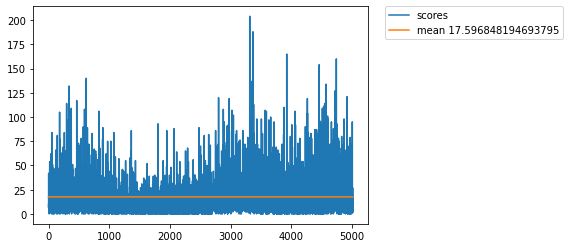

In [10]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams (should be sufficient)
episodes = 10000
annealing_steps = 100000  # not episodes!
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.000004
alpha = 0.0001
batch_size = 64
memory_size = 200000
start_replay_step = 100000
target_model_update_interval = 1000
train_freq = 4

agent = DQNAgent(action_size=action_size, state_size=state_size, gamma=gamma, 
                 epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
                 alpha=alpha, batch_size=batch_size, memory_size=memory_size,
                 start_replay_step=start_replay_step, 
                 target_model_update_interval=target_model_update_interval, train_freq=train_freq)

statistics = interact_with_environment(env, agent, n_episodes=episodes, verbose=True)
env.close()
plot_statistics(statistics)

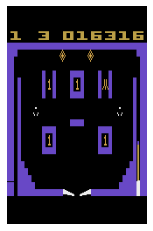

In [11]:
for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

In [ ]:
tf.keras.utils.plot_model(agent.model, to_file='keras_plot_model_2.png', show_shapes=True)
display.Image('keras_plot_model_2.png')

In [ ]:
import pickle
from os import path

save_dir = "./saved_model"

In [14]:
agent.model.save(path.join(save_dir, "model.tf"))
agent.target_model.save(path.join(save_dir, "target_model.tf"))

In [15]:
agent.model = None
agent.target_model = None

In [ ]:
with open(path.join(save_dir, "agent.pkl"), "wb") as f:
    pickle.dump(agent, f)
    f.close()

Load the model

In [ ]:
with open(path.join(save_dir, "agent.pkl"), "rb") as f:
    agent = pickle.load(f)
    f.close()

agent.model = tf.keras.models.load_model(path.join(save_dir, "model.tf"))
agent.target_model = tf.keras.models.load_model(path.join(save_dir, "target_model.tf"))

## To-Dos

- Create on place for hyperparameters for inside the model and pass it on
  - e. g. optimizer, different metrics, checkpointing for the internal model, etc.